## Cell 1: Environment Setup

In [18]:
from google.colab import drive
import os
import time
import glob

drive.mount('/content/drive')
!pip install -q einops scikit-image pandas opencv-python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Cell 2: Data Copy to RAM & Verify

In [19]:
print("Copying dataset to RAM disk...")
gdrive_dataset_path = "/content/drive/MyDrive/Datasets"
local_dataset_path = "/dev/shm/datasets"
start_time = time.time()
if os.path.exists(gdrive_dataset_path):
    !rsync -a --info=progress2 {gdrive_dataset_path} {local_dataset_path}
    print(f"Copy completed in {time.time() - start_time:.2f} seconds")
    local_base = os.path.join(local_dataset_path, os.path.basename(gdrive_dataset_path.rstrip('/')))
    div2k_count = len(glob.glob(os.path.join(local_base, 'DIV2K/HR/*.png')))
    flickr2k_count = len(glob.glob(os.path.join(local_base, 'Flickr2K/HR/*.png')))
    print(f"✅ Found {div2k_count + flickr2k_count} training images in RAM.")
else:
    print(f"❌ ERROR: Dataset path not found: {gdrive_dataset_path}")

Copying dataset to RAM disk...
              0 100%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/1)
Copy completed in 0.10 seconds
✅ Found 3450 training images in RAM.


## Cell 3: Project Configuration

In [20]:
import os

class ProgressiveConfig:
    DRIVE_PREFIX = '/content/drive/MyDrive/'
    PROJECT_DIR = os.path.join(DRIVE_PREFIX, 'FusionSR_v7_4')
    BEST_MODEL_DIR = os.path.join(PROJECT_DIR, 'best_models')
    V5_MODEL_PATH = '/content/drive/MyDrive/FusionSR_ClassicalSR_v5/best_models/fusionsr_classical_best_v5.pth'

    LOCAL_DATASET_BASE = '/dev/shm/datasets/Datasets/'
    TRAIN_HR_DIRS = [os.path.join(LOCAL_DATASET_BASE, 'DIV2K/HR'), os.path.join(LOCAL_DATASET_BASE, 'Flickr2K/HR')]
    VAL_HR_DIR = os.path.join(LOCAL_DATASET_BASE, 'Set14/image_SRF_4')

    TOTAL_EPOCHS = 50
    STAGE1_EPOCHS = 15
    STAGE2_EPOCHS = 20
    STAGE3_EPOCHS = 15

    STAGE1_LR = 1e-4
    STAGE2_LR = 5e-5
    STAGE3_LR = 1e-5

    BATCH_SIZE = 16
    PATCHES_PER_IMAGE = 4
    HR_PATCH_SIZE = 256
    VGG_LOSS_WEIGHT = 0.1
    GRADIENT_CLIP_VAL = 0.5

    try:
        NUM_WORKERS = os.cpu_count()
    except:
        NUM_WORKERS = 4

    UPSCALE_FACTOR = 4; BASE_DIM = 180; NUM_BLOCKS = 8; NUM_HEADS = 6; WINDOW_SIZE = 8
    CHANNEL_REDUCTION_RATIO = 16

os.makedirs(ProgressiveConfig.BEST_MODEL_DIR, exist_ok=True)
print(f"Project directory: {ProgressiveConfig.PROJECT_DIR}")
print(f"Using {ProgressiveConfig.NUM_WORKERS} CPU cores for DataLoader.")

Project directory: /content/drive/MyDrive/FusionSR_v7_4
Using 12 CPU cores for DataLoader.


## Cell 4: Data Pipeline Definition

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class DynamicSRDataset(Dataset):
    def __init__(self, hr_dirs):
        super().__init__()
        self.hr_paths = []
        for d in hr_dirs:
            self.hr_paths.extend(glob.glob(os.path.join(d, '*.png')))
            self.hr_paths.extend(glob.glob(os.path.join(d, '*_HR.png')))
        print(f"✅ Found {len(self.hr_paths)} images. Skipping size check.")

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        hr_image = Image.open(self.hr_paths[idx]).convert('RGB')
        return transforms.ToTensor()(hr_image)

class ValidationSRDataset(Dataset):
    def __init__(self, hr_dirs, hr_patch_size):
        super().__init__()
        self.hr_paths = []
        for d in hr_dirs:
            self.hr_paths.extend(glob.glob(os.path.join(d, '*.png')))
            self.hr_paths.extend(glob.glob(os.path.join(d, '*_HR.png')))
        self.hr_patch_size = hr_patch_size
    def __len__(self):
        return len(self.hr_paths)
    def __getitem__(self, idx):
        hr_image = Image.open(self.hr_paths[idx]).convert('RGB')
        hr_patch = transforms.CenterCrop(self.hr_patch_size)(hr_image)
        return transforms.ToTensor()(hr_patch)

## Cell 5: Model Architecture

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torchvision import models

class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=True),
            nn.GELU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=True)
        )
        self.sigmoid = nn.Sigmoid()
        nn.init.constant_(self.fc[-1].weight, 0)
        nn.init.constant_(self.fc[-1].bias, 0)
    def forward(self, x):
        attention = self.sigmoid(self.fc(self.avg_pool(x)))
        return x * (0.5 + 0.5 * attention)

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.conv_block = nn.Sequential(nn.Conv2d(channels, channels, 3, 1, 1), nn.GELU(), nn.Conv2d(channels, channels, 3, 1, 1))
        self.channel_attention = ChannelAttention(channels, reduction)
        self.residual_scale = nn.Parameter(torch.zeros(1))
    def forward(self, x):
        residual = x; out = self.conv_block(x); out = self.channel_attention(out)
        return residual + self.residual_scale * out

class ProgressiveShallowExtractor(nn.Module):
    def __init__(self, in_channels, out_channels, use_rca=True):
        super().__init__()
        self.use_rca = use_rca
        self.original_path = nn.Sequential(
            nn.Conv2d(in_channels, out_channels // 2, 3, 1, 1), nn.GELU(),
            nn.Conv2d(out_channels // 2, out_channels // 2, 3, 1, 1), nn.GELU(),
            nn.Conv2d(out_channels // 2, out_channels, 1, 1, 0)
        )
        if use_rca:
            self.enhanced_path = nn.Sequential(
                nn.Conv2d(in_channels, out_channels // 2, 3, 1, 1), nn.GELU(),
                ResidualChannelAttentionBlock(out_channels // 2),
                ResidualChannelAttentionBlock(out_channels // 2),
                nn.Conv2d(out_channels // 2, out_channels, 1, 1, 0)
            )
            self.mix_weight = nn.Parameter(torch.tensor(0.1))
    def forward(self, x):
        original_features = self.original_path(x)
        if not self.use_rca: return original_features
        enhanced_features = self.enhanced_path(x)
        mix_ratio = torch.sigmoid(self.mix_weight)
        return (1 - mix_ratio) * original_features + mix_ratio * enhanced_features

def window_partition(x, window_size):
    B, H, W, C = x.shape; x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C); return windows
def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size)); x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1); return x
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__(); self.num_heads = num_heads; self.head_dim = dim // num_heads; self.scale = self.head_dim ** -0.5; self.qkv = nn.Linear(dim, dim * 3, bias=True); self.proj = nn.Linear(dim, dim)
        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size - 1) * (2 * window_size - 1), num_heads))
        coords_h = torch.arange(window_size); coords_w = torch.arange(window_size); coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing='ij')); coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]; relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += window_size - 1; relative_coords[:, :, 1] += window_size - 1; relative_coords[:, :, 0] *= 2 * window_size - 1
        relative_position_index = relative_coords.sum(-1); self.register_buffer("relative_position_index", relative_position_index); nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
    def forward(self, x, mask=None):
        B_, N, C = x.shape; qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4); q, k, v = qkv.unbind(0); attn = (q @ k.transpose(-2, -1)) * self.scale
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(N, N, -1).permute(2, 0, 1).contiguous(); attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nW = mask.shape[0]; attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0); attn = attn.view(-1, self.num_heads, N, N)
        attn = F.softmax(attn, dim=-1); x = (attn @ v).transpose(1, 2).reshape(B_, N, C); return self.proj(x)
class SwinBlock(nn.Module):
    def __init__(self, dim, num_heads, window_size, shift_size=0):
        super().__init__(); self.norm1 = nn.LayerNorm(dim); self.attn = WindowAttention(dim, num_heads, window_size); self.norm2 = nn.LayerNorm(dim); self.mlp = nn.Sequential(nn.Linear(dim, dim * 4), nn.GELU(), nn.Linear(dim * 4, dim)); self.window_size = window_size; self.shift_size = shift_size
    def forward(self, x, H, W):
        B, L, C = x.shape; shortcut = x; x = self.norm1(x); x = x.view(B, H, W, C);
        pad_b = (self.window_size - H % self.window_size) % self.window_size; pad_r = (self.window_size - W % self.window_size) % self.window_size; x = F.pad(x, (0, 0, 0, pad_r, 0, pad_b)); _, H_pad, W_pad, _ = x.shape
        if self.shift_size > 0: shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else: shifted_x = x
        x_windows = window_partition(shifted_x, self.window_size); x_windows = x_windows.view(-1, self.window_size * self.window_size, C); attn_mask = None
        if self.shift_size > 0:
            img_mask = torch.zeros((1, H_pad, W_pad, 1), device=x.device); h_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None)); w_slices = (slice(0, -self.window_size), slice(-self.window_size, -self.shift_size), slice(-self.shift_size, None)); cnt = 0
            for h in h_slices:
                for w in w_slices: img_mask[:, h, w, :] = cnt; cnt += 1
            mask_windows = window_partition(img_mask, self.window_size); mask_windows = mask_windows.view(-1, self.window_size * self.window_size); attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2); attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        attn_windows = self.attn(x_windows, mask=attn_mask); shifted_x = window_reverse(attn_windows, self.window_size, H_pad, W_pad)
        if self.shift_size > 0: x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else: x = shifted_x
        if pad_r > 0 or pad_b > 0: x = x[:, :H, :W, :].contiguous()
        x = x.view(B, L, C); x = shortcut + x; x = x + self.mlp(self.norm2(x)); return x
class FusionSRv7(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.conv_first = ProgressiveShallowExtractor(in_channels=3, out_channels=config.BASE_DIM, use_rca=True)
        self.body = nn.ModuleList([SwinBlock(dim=config.BASE_DIM, num_heads=config.NUM_HEADS, window_size=config.WINDOW_SIZE, shift_size=0 if (i % 2 == 0) else config.WINDOW_SIZE // 2) for i in range(config.NUM_BLOCKS)])
        self.feature_fusion = nn.Sequential(nn.Conv2d(config.BASE_DIM * 2, config.BASE_DIM, 1, 1, 0), nn.GELU(), nn.Conv2d(config.BASE_DIM, config.BASE_DIM, 3, 1, 1))
        self.upsample = nn.Sequential(nn.Conv2d(config.BASE_DIM, 3 * (config.UPSCALE_FACTOR ** 2), 3, 1, 1), nn.PixelShuffle(config.UPSCALE_FACTOR))
    def forward(self, x):
        B, C, H, W = x.shape; shallow_features = self.conv_first(x)
        deep_features_in = rearrange(shallow_features, 'b c h w -> b (h w) c')
        for block in self.body: deep_features_in = block(deep_features_in, H, W)
        deep_features = rearrange(deep_features_in, 'b (h w) c -> b c h w', h=H, w=W)
        fused_features = self.feature_fusion(torch.cat((shallow_features, deep_features), dim=1))
        return self.upsample(fused_features)
    def set_progressive_mode(self, stage):
        if stage == 1: self.freeze_backbone(); self.unfreeze_rca_components()
        elif stage == 2: self.freeze_backbone(); self.unfreeze_shallow_features()
        elif stage == 3: self.unfreeze_all()
    def freeze_backbone(self):
        for param in self.body.parameters(): param.requires_grad = False
        for param in self.feature_fusion.parameters(): param.requires_grad = False
        for param in self.upsample.parameters(): param.requires_grad = False
    def unfreeze_rca_components(self):
        if hasattr(self.conv_first, 'enhanced_path'):
            for param in self.conv_first.enhanced_path.parameters(): param.requires_grad = True
            self.conv_first.mix_weight.requires_grad = True
    def unfreeze_shallow_features(self):
        for param in self.conv_first.parameters(): param.requires_grad = True
    def unfreeze_all(self):
        for param in self.parameters(): param.requires_grad = True
class CharbonnierLoss(nn.Module):
    def __init__(self, eps=1e-3): super().__init__(); self.eps = eps
    def forward(self, x, y): diff = x - y; return torch.mean(torch.sqrt(diff * diff + self.eps**2))
class VGGPerceptualLoss(nn.Module):
    def __init__(self, device):
        super().__init__(); vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features[:36].eval().to(device)
        for param in vgg.parameters(): param.requires_grad = False
        self.vgg = vgg; self.loss = nn.L1Loss()
    def forward(self, x, y): return self.loss(self.vgg(x), self.vgg(y))

## Cell 6: Progressive Training with Dynamic GPU Pipeline

In [23]:
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

class GPUDynamicDataLoader:
    def __init__(self, dataloader, device, config):
        self.dataloader = dataloader; self.device = device; self.config = config
        self.gpu_downsampler = transforms.Resize(
            size=config.HR_PATCH_SIZE // config.UPSCALE_FACTOR,
            interpolation=transforms.InterpolationMode.BICUBIC, antialias=True
        ).to(device)
        self.gpu_augmentations = torch.nn.Sequential(
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
        ).to(device)
    def __iter__(self):
        for full_images_list in self.dataloader:
            full_images_on_gpu = [img.to(self.device, non_blocking=True) for img in full_images_list]
            hr_patches = self._extract_random_patches_gpu(full_images_on_gpu)
            if torch.rand(1) < 0.8:
                hr_patches = self.gpu_augmentations(hr_patches)
            lr_patches = self.gpu_downsampler(hr_patches)
            yield lr_patches, hr_patches
    def __len__(self):
        return len(self.dataloader)
    def _extract_random_patches_gpu(self, images_list):
        all_patches = []
        for img in images_list:
            _, h, w = img.shape
            for _ in range(self.config.PATCHES_PER_IMAGE):
                if h >= self.config.HR_PATCH_SIZE and w >= self.config.HR_PATCH_SIZE:
                    top = torch.randint(0, h - self.config.HR_PATCH_SIZE + 1, (1,)).item()
                    left = torch.randint(0, w - self.config.HR_PATCH_SIZE + 1, (1,)).item()
                    patch = img[:, top:top+self.config.HR_PATCH_SIZE, left:left+self.config.HR_PATCH_SIZE]
                else:
                    patch = transforms.functional.resize(
                        img.unsqueeze(0), (self.config.HR_PATCH_SIZE, self.config.HR_PATCH_SIZE),
                        interpolation=transforms.InterpolationMode.BICUBIC, antialias=True
                    ).squeeze(0)
                all_patches.append(patch)
        return torch.stack(all_patches, dim=0)

def validate_model(model, val_loader, device, config):
    model.eval(); total_psnr = 0.0; total_ssim = 0.0
    gpu_downsampler = transforms.Resize(
        size=config.HR_PATCH_SIZE // config.UPSCALE_FACTOR,
        interpolation=transforms.InterpolationMode.BICUBIC, antialias=True
    ).to(device)
    with torch.no_grad():
        for hr_patches in val_loader:
            hr_patches = hr_patches.to(device, non_blocking=True)
            lr_patches = gpu_downsampler(hr_patches)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                sr_patches = model(lr_patches)
            sr_patches = sr_patches.clamp(0, 1).cpu().float(); hr_patches = hr_patches.cpu().float()
            for i in range(sr_patches.shape[0]):
                sr_np = sr_patches[i].permute(1, 2, 0).numpy()
                hr_np = hr_patches[i].permute(1, 2, 0).numpy()
                total_psnr += peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0)
                total_ssim += structural_similarity(hr_np, sr_np, channel_axis=2, data_range=1.0)
    return total_psnr / len(val_loader.dataset), total_ssim / len(val_loader.dataset)

def dynamic_collate_fn(batch):
    return batch

def progressive_training():
    DEVICE = torch.device('cuda'); config = ProgressiveConfig
    train_cpu_loader = DataLoader(
        DynamicSRDataset(config.TRAIN_HR_DIRS),
        batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS,
        pin_memory=True, persistent_workers=True, collate_fn=dynamic_collate_fn
    )
    gpu_train_loader = GPUDynamicDataLoader(train_cpu_loader, DEVICE, config)

    val_loader = DataLoader(
        ValidationSRDataset([config.VAL_HR_DIR], config.HR_PATCH_SIZE),
        batch_size=config.BATCH_SIZE * config.PATCHES_PER_IMAGE,
        num_workers=config.NUM_WORKERS
    )
    model = FusionSRv7(config).to(DEVICE)
    if os.path.exists(config.V5_MODEL_PATH):
        print(f"Loading v5 weights from: {config.V5_MODEL_PATH}")
        v5_state_dict = torch.load(config.V5_MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(v5_state_dict, strict=False)
        print(f"✅ Weights loaded.")
    model = torch.compile(model)
    criterion_pix = CharbonnierLoss().to(DEVICE); criterion_vgg = VGGPerceptualLoss(device=DEVICE); scaler = GradScaler()
    best_psnr = 25.0; current_epoch = 0; print("🚀 Starting Progressive Training"); print("=" * 60)

    print(f"📍 STAGE 1 (Epochs 1-{config.STAGE1_EPOCHS})")
    model.set_progressive_mode(stage=1)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config.STAGE1_LR)
    for epoch in range(config.STAGE1_EPOCHS):
        current_epoch += 1; model.train()
        progress_bar = tqdm(gpu_train_loader, desc=f"Stage 1 - Epoch {current_epoch}/{config.TOTAL_EPOCHS}")
        for lr_imgs, hr_imgs in progress_bar:
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                sr_imgs = model(lr_imgs); loss = criterion_pix(sr_imgs, hr_imgs) + config.VGG_LOSS_WEIGHT * criterion_vgg(sr_imgs, hr_imgs)
            scaler.scale(loss).backward(); scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP_VAL); scaler.step(optimizer); scaler.update()
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        val_psnr, val_ssim = validate_model(model, val_loader, DEVICE, config)
        print(f"Stage 1 - Epoch {current_epoch} | Val PSNR: {val_psnr:.4f} | Val SSIM: {val_ssim:.4f}")
        if val_psnr > best_psnr:
            best_psnr = val_psnr; torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, "fusionsr_v7_best.pth")); print(f"✅ Best model saved: {best_psnr:.4f}")
        torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, f"checkpoint_epoch_{current_epoch}.pth"))

    print(f"📍 STAGE 2 (Epochs {config.STAGE1_EPOCHS+1}-{config.STAGE1_EPOCHS+config.STAGE2_EPOCHS})")
    model.set_progressive_mode(stage=2)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=config.STAGE2_LR)
    for epoch in range(config.STAGE2_EPOCHS):
        current_epoch += 1; model.train()
        progress_bar = tqdm(gpu_train_loader, desc=f"Stage 2 - Epoch {current_epoch}/{config.TOTAL_EPOCHS}")
        for lr_imgs, hr_imgs in progress_bar:
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                sr_imgs = model(lr_imgs); loss = criterion_pix(sr_imgs, hr_imgs) + config.VGG_LOSS_WEIGHT * criterion_vgg(sr_imgs, hr_imgs)
            scaler.scale(loss).backward(); scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP_VAL); scaler.step(optimizer); scaler.update()
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        val_psnr, val_ssim = validate_model(model, val_loader, DEVICE, config)
        print(f"Stage 2 - Epoch {current_epoch} | Val PSNR: {val_psnr:.4f} | Val SSIM: {val_ssim:.4f}")
        if val_psnr > best_psnr:
            best_psnr = val_psnr; torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, "fusionsr_v7_best.pth")); print(f"✅ Best model saved: {best_psnr:.4f}")
        torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, f"checkpoint_epoch_{current_epoch}.pth"))

    print(f"📍 STAGE 3 (Epochs {config.STAGE1_EPOCHS+config.STAGE2_EPOCHS+1}-{config.TOTAL_EPOCHS})")
    model.set_progressive_mode(stage=3)
    optimizer = optim.AdamW(model.parameters(), lr=config.STAGE3_LR)
    for epoch in range(config.STAGE3_EPOCHS):
        current_epoch += 1; model.train()
        progress_bar = tqdm(gpu_train_loader, desc=f"Stage 3 - Epoch {current_epoch}/{config.TOTAL_EPOCHS}")
        for lr_imgs, hr_imgs in progress_bar:
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                sr_imgs = model(lr_imgs); loss = criterion_pix(sr_imgs, hr_imgs) + config.VGG_LOSS_WEIGHT * criterion_vgg(sr_imgs, hr_imgs)
            scaler.scale(loss).backward(); scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP_VAL); scaler.step(optimizer); scaler.update()
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}"})
        val_psnr, val_ssim = validate_model(model, val_loader, DEVICE, config)
        print(f"Stage 3 - Epoch {current_epoch} | Val PSNR: {val_psnr:.4f} | Val SSIM: {val_ssim:.4f}")
        if val_psnr > best_psnr:
            best_psnr = val_psnr; torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, "fusionsr_v7_best.pth")); print(f"✅ Best model saved: {best_psnr:.4f}")
        torch.save(model._orig_mod.state_dict(), os.path.join(config.BEST_MODEL_DIR, f"checkpoint_epoch_{current_epoch}.pth"))

    print(f"🎉 Progressive Training Completed! Best PSNR: {best_psnr:.4f}")

#progressive_training()

## Cell 7: Benchmarking

In [26]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import torch
from torch.amp import autocast
from torchvision import transforms

class BenchmarkDataset(Dataset):
    def __init__(self, hr_dirs, upscale_factor):
        self.hr_paths = []
        self.upscale_factor = upscale_factor
        self.to_tensor = transforms.ToTensor()
        for d in hr_dirs:
            if os.path.exists(d):
                self.hr_paths.extend(glob.glob(os.path.join(d, '*.png')))
                self.hr_paths.extend(glob.glob(os.path.join(d, '*_HR.png')))
    def __len__(self):
        return len(self.hr_paths)
    def __getitem__(self, idx):
        hr_image = Image.open(self.hr_paths[idx]).convert('RGB')
        w, h = hr_image.size
        crop_w = w - (w % self.upscale_factor)
        crop_h = h - (h % self.upscale_factor)
        hr_image = transforms.functional.center_crop(hr_image, (crop_h, crop_w))
        lr_image = hr_image.resize(
            (hr_image.width // self.upscale_factor, hr_image.height // self.upscale_factor),
            Image.BICUBIC
        )
        return self.to_tensor(lr_image), self.to_tensor(hr_image)

def comprehensive_benchmark():
    DEVICE = torch.device('cuda'); config = ProgressiveConfig

    # Fix: Use the correct path from the config
    best_model_path = os.path.join(config.BEST_MODEL_DIR, "fusionsr_v7_best.pth")
    if not os.path.exists(best_model_path):
        print(f"Model not found at {best_model_path}")
        print("Available models:")
        if os.path.exists(config.BEST_MODEL_DIR):
            for f in os.listdir(config.BEST_MODEL_DIR):
                if f.endswith('.pth'):
                    print(f"  - {f}")
        return

    model = FusionSRv7(config).to(DEVICE)
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()
    print(f"✅ Model loaded from {best_model_path}")

    # Fix: Define the benchmark dataset paths based on available datasets
    local_dataset_base = config.LOCAL_DATASET_BASE
    benchmark_datasets = {
        "Set14": [config.VAL_HR_DIR],  # Use the existing validation directory
        "DIV2K_Val": [os.path.join(local_dataset_base, 'DIV2K/valid_HR')] if os.path.exists(os.path.join(local_dataset_base, 'DIV2K/valid_HR')) else [],
        "Set5": [os.path.join(local_dataset_base, 'Set5/image_SRF_4')] if os.path.exists(os.path.join(local_dataset_base, 'Set5/image_SRF_4')) else [],
        "BSD100": [os.path.join(local_dataset_base, 'BSD100/image_SRF_4')] if os.path.exists(os.path.join(local_dataset_base, 'BSD100/image_SRF_4')) else [],
        "Urban100": [os.path.join(local_dataset_base, 'Urban100/image_SRF_4')] if os.path.exists(os.path.join(local_dataset_base, 'Urban100/image_SRF_4')) else [],
        "Manga109": [os.path.join(local_dataset_base, 'Manga109/image_SRF_4')] if os.path.exists(os.path.join(local_dataset_base, 'Manga109/image_SRF_4')) else []
    }

    # Remove empty dataset paths
    benchmark_datasets = {k: v for k, v in benchmark_datasets.items() if v and os.path.exists(v[0])}

    results = []
    print("\n--- FULL IMAGE BENCHMARK RESULTS ---")

    with torch.no_grad():
        for name, path in benchmark_datasets.items():
            if not path or not os.path.exists(path[0]):
                print(f"\n⚠️  Skipping {name}: Dataset not found at {path}")
                continue

            # Check if there are any images in the directory
            test_files = glob.glob(os.path.join(path[0], '*.png'))
            if not test_files:
                print(f"\n⚠️  Skipping {name}: No PNG files found in {path[0]}")
                continue

            dataset = BenchmarkDataset(path, config.UPSCALE_FACTOR)
            if len(dataset) == 0:
                print(f"\n⚠️  Skipping {name}: Empty dataset")
                continue

            loader = DataLoader(dataset, batch_size=1, shuffle=False)
            psnr_scores, ssim_scores = [], []

            for lr_tensor, hr_tensor in tqdm(loader, desc=f"Benchmarking {name}"):
                lr_tensor = lr_tensor.to(DEVICE)
                with autocast(device_type='cuda', dtype=torch.bfloat16):
                    sr_tensor = model(lr_tensor)

                sr_tensor = sr_tensor.clamp(0, 1).cpu().float()
                hr_tensor = hr_tensor.cpu().float()
                sr_np = sr_tensor.squeeze(0).permute(1, 2, 0).numpy()
                hr_np = hr_tensor.squeeze(0).permute(1, 2, 0).numpy()

                psnr_scores.append(peak_signal_noise_ratio(hr_np, sr_np, data_range=1.0))
                ssim_scores.append(structural_similarity(hr_np, sr_np, channel_axis=2, data_range=1.0))

            if psnr_scores and ssim_scores:
                avg_psnr = np.mean(psnr_scores); avg_ssim = np.mean(ssim_scores)
                results.append({"Dataset": name, "Images": len(psnr_scores), "PSNR (dB)": f"{avg_psnr:.3f}", "SSIM": f"{avg_ssim:.4f}"})
                print(f"✅ {name}: {len(psnr_scores)} images, PSNR: {avg_psnr:.3f}, SSIM: {avg_ssim:.4f}")

    if results:
        results_df = pd.DataFrame(results)
        print("\n" + "="*50)
        print("🏆 FUSIONSR V7 BENCHMARK RESULTS")
        print("="*50)
        print(results_df.to_string(index=False))
        print("="*50)
    else:
        print("\n❌ No benchmark datasets found or processed successfully.")
        print("Available directories in dataset base:")
        if os.path.exists(local_dataset_base):
            for item in os.listdir(local_dataset_base):
                item_path = os.path.join(local_dataset_base, item)
                if os.path.isdir(item_path):
                    print(f"  📁 {item}")
        else:
            print(f"  Dataset base directory not found: {local_dataset_base}")

comprehensive_benchmark()

✅ Model loaded from /content/drive/MyDrive/FusionSR_v7_4/best_models/fusionsr_v7_best.pth

--- FULL IMAGE BENCHMARK RESULTS ---


Benchmarking Set14: 100%|██████████| 42/42 [00:02<00:00, 17.63it/s]


✅ Set14: 42 images, PSNR: 23.533, SSIM: 0.6849


Benchmarking Set5: 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


✅ Set5: 15 images, PSNR: 25.150, SSIM: 0.7466


Benchmarking BSD100: 100%|██████████| 300/300 [01:31<00:00,  3.28it/s]


✅ BSD100: 300 images, PSNR: 24.544, SSIM: 0.6830


Benchmarking Urban100: 100%|██████████| 300/300 [02:32<00:00,  1.97it/s]

✅ Urban100: 300 images, PSNR: 21.591, SSIM: 0.6484

🏆 FUSIONSR V7 BENCHMARK RESULTS
 Dataset  Images PSNR (dB)   SSIM
   Set14      42    23.533 0.6849
    Set5      15    25.150 0.7466
  BSD100     300    24.544 0.6830
Urban100     300    21.591 0.6484


## Cell 8: Inference

✅ Model loaded for inference.
📤 Please upload a low-resolution image:


Saving Spring nature wallpaper.jpg to Spring nature wallpaper (1).jpg
Processing: Spring nature wallpaper (1).jpg
Original image size: (516, 343)
Input tensor shape: torch.Size([1, 3, 343, 516])
Upscaled image size: (2064, 1372)


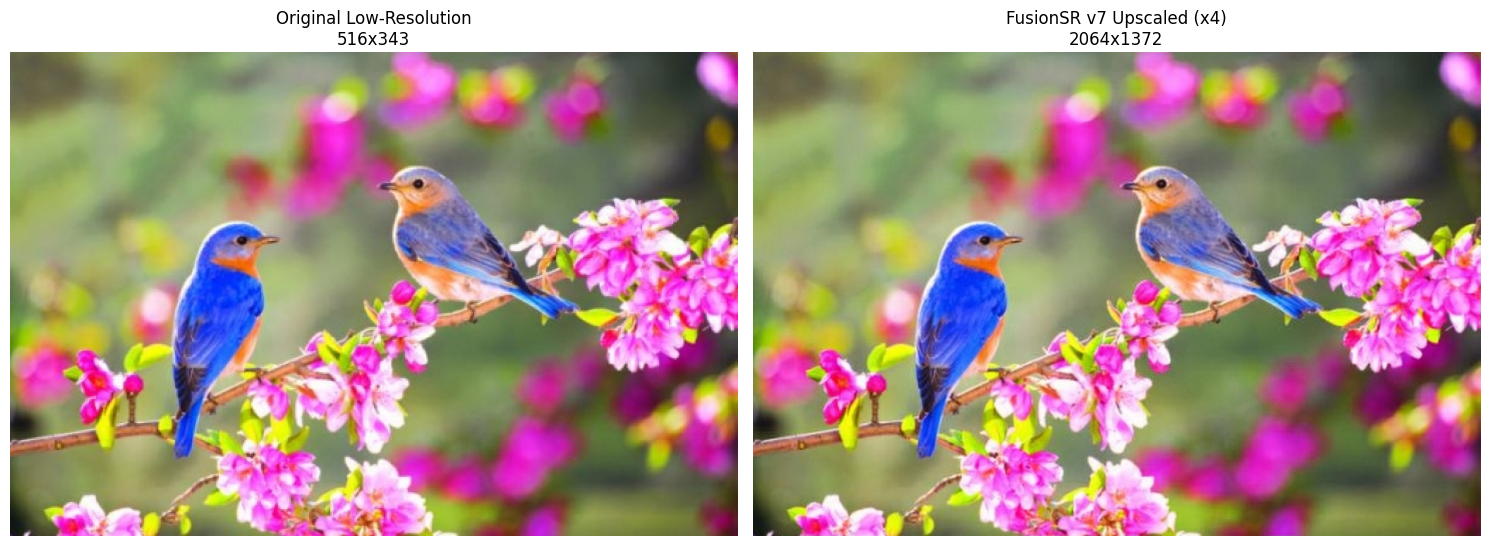


💾 Save upscaled image?
Enter 'y' to download the upscaled image: y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded: Spring nature wallpaper (1)_fusionsr_v7_x4.png


In [30]:
from google.colab import files
import io
import matplotlib.pyplot as plt

def run_inference():
    DEVICE = torch.device('cuda'); config = ProgressiveConfig
    best_model_path = os.path.join(config.BEST_MODEL_DIR, "fusionsr_v7_best.pth")
    if not os.path.exists(best_model_path):
        print(f"Model not found at {best_model_path}")
        print("Available models:")
        if os.path.exists(config.BEST_MODEL_DIR):
            for f in os.listdir(config.BEST_MODEL_DIR):
                if f.endswith('.pth'):
                    print(f"  - {f}")
        return

    model = FusionSRv7(config).to(DEVICE)
    model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
    model.eval()
    print(f"✅ Model loaded for inference.")

    print("📤 Please upload a low-resolution image:")
    uploaded = files.upload()
    if not uploaded:
        print("No image uploaded."); return

    filename = list(uploaded.keys())[0]
    print(f"Processing: {filename}")

    try:
        lr_image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
        print(f"Original image size: {lr_image.size}")

        lr_tensor = transforms.ToTensor()(lr_image).unsqueeze(0).to(DEVICE)
        print(f"Input tensor shape: {lr_tensor.shape}")

        with torch.no_grad():
            # Use float32 for inference to avoid BFloat16 compatibility issues
            sr_tensor = model(lr_tensor.float())

        sr_image = transforms.ToPILImage()(sr_tensor.squeeze(0).clamp(0, 1).cpu())
        print(f"Upscaled image size: {sr_image.size}")

        # Display results
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))
        axes[0].imshow(lr_image)
        axes[0].set_title(f"Original Low-Resolution\n{lr_image.size[0]}x{lr_image.size[1]}")
        axes[0].axis('off')

        axes[1].imshow(sr_image)
        axes[1].set_title(f"FusionSR v7 Upscaled (x{config.UPSCALE_FACTOR})\n{sr_image.size[0]}x{sr_image.size[1]}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # Option to download the result
        print("\n💾 Save upscaled image?")
        save_choice = input("Enter 'y' to download the upscaled image: ").lower().strip()
        if save_choice == 'y':
            # Save to bytes buffer for download
            img_buffer = io.BytesIO()
            sr_image.save(img_buffer, format='PNG')
            img_buffer.seek(0)

            # Generate output filename
            base_name = os.path.splitext(filename)[0]
            output_filename = f"{base_name}_fusionsr_v7_x{config.UPSCALE_FACTOR}.png"

            # Save locally and trigger download
            sr_image.save(output_filename)
            files.download(output_filename)
            print(f"✅ Downloaded: {output_filename}")

    except Exception as e:
        print(f"❌ Error processing image: {str(e)}")
        print("Make sure you uploaded a valid image file (PNG, JPG, etc.)")

run_inference()